In [1]:
import gc
import tensorflow as tf

tf.keras.backend.clear_session()
import gc

gc.collect()


0

In [2]:
from tensorflow.keras import backend as K
K.clear_session()

In [3]:
print(tf.config.list_physical_devices())
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [17]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense ,Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
%matplotlib inline 
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

In [5]:
import os
import random
import shutil

In [6]:
# Define the original directories
real_dir = r"E:\Datasets\deep fake\Imagec_complwtw\Images\Train\Real"
fake_dir = r"E:\Datasets\deep fake\Imagec_complwtw\Images\Train\Fake"

In [7]:

# Define the new base directory for the split dataset
base_dir = r"E:\Datasets\deep_fake_split"
os.makedirs(base_dir, exist_ok=True)

In [8]:
# Create the subdirectories
dirs = ['train', 'test', 'valid']
categories = ['Real', 'Fake']

In [8]:
for dir_name in dirs:
    for category in categories:
        os.makedirs(os.path.join(base_dir, dir_name, category), exist_ok=True)

In [9]:
# Function to copy images to a specific directory
def copy_images(src_dir, dest_dir, images):
    for image in images:
        shutil.copy(os.path.join(src_dir, image), os.path.join(dest_dir, image))

In [10]:
# Function to split and move data
def split_data(src_dir, train_size, test_size, valid_size):
    images = [img for img in os.listdir(src_dir) if img.endswith(('jpg', 'jpeg', 'png'))]
    random.shuffle(images)
    
    train_images = images[:train_size]
    test_images = images[train_size:train_size + test_size]
    valid_images = images[train_size + test_size:train_size + test_size + valid_size]
    
    return train_images, test_images, valid_images

In [11]:
# Define the number of images for each subset based on total size of 20,000 images
train_size = 14000  # 70% of the data
test_size = 3000    # 15% of the data
valid_size = 3000   # 15% of the data

In [16]:
# Split and copy images for Real
real_train_images, real_test_images, real_valid_images = split_data(real_dir, train_size, test_size, valid_size)
copy_images(real_dir, os.path.join(base_dir, 'train', 'Real'), real_train_images)
copy_images(real_dir, os.path.join(base_dir, 'test', 'Real'), real_test_images)
copy_images(real_dir, os.path.join(base_dir, 'valid', 'Real'), real_valid_images)

# Split and copy images for Fake
fake_train_images, fake_test_images, fake_valid_images = split_data(fake_dir, train_size, test_size, valid_size)
copy_images(fake_dir, os.path.join(base_dir, 'train', 'Fake'), fake_train_images)
copy_images(fake_dir, os.path.join(base_dir, 'test', 'Fake'), fake_test_images)
copy_images(fake_dir, os.path.join(base_dir, 'valid', 'Fake'), fake_valid_images)

print("Data split into train/test/valid successfully.")


Data split into train/test/valid successfully.


In [15]:
train_dir = r"E:\Datasets\deep_fake_split\train"
valid_dir = r"E:\Datasets\deep_fake_split\valid"
test_dir = r"E:\Datasets\deep_fake_split\test"

In [18]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    classes=['Real', 'Fake'],  # Update to Real and Fake
    batch_size=20
)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_dir,
    target_size=(224, 224),
    classes=['Real', 'Fake'],  # Update to Real and Fake
    batch_size=20
)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    classes=['Real', 'Fake'],  # Update to Real and Fake
    batch_size=20,
    shuffle=False  # Shuffle is typically set to False for test data
)

Found 28000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


In [11]:
with tf.device('/CPU:0'):
    vgg16_base = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))

In [12]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# Freeze the convolutional base
vgg16_base.trainable = False

In [19]:
model = tf.keras.Sequential([
    vgg16_base,                           
    Flatten(),                            
    Dense(units=256, activation='relu'),  
    Dense(units=128, activation='relu'), 
    Dense(units=2, activation='softmax') 
])


In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 21,170,626
Trainable params: 6,455,938
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [25]:
history = model.fit(
    train_batches,               
    validation_data=valid_batches,
    epochs=3,                     
    batch_size=20,                
    callbacks=[early_stopping]  
)

Epoch 1/3
1400/1400 [==============================] - 444s 306ms/step - loss: 0.6536 - accuracy: 0.7660 - val_loss: 0.4074 - val_accuracy: 0.8108
Epoch 2/3
1400/1400 [==============================] - 527s 376ms/step - loss: 0.3635 - accuracy: 0.8536 - val_loss: 0.4245 - val_accuracy: 0.8243
Epoch 3/3
1400/1400 [==============================] - 510s 364ms/step - loss: 0.2696 - accuracy: 0.8917 - val_loss: 0.4263 - val_accuracy: 0.8155


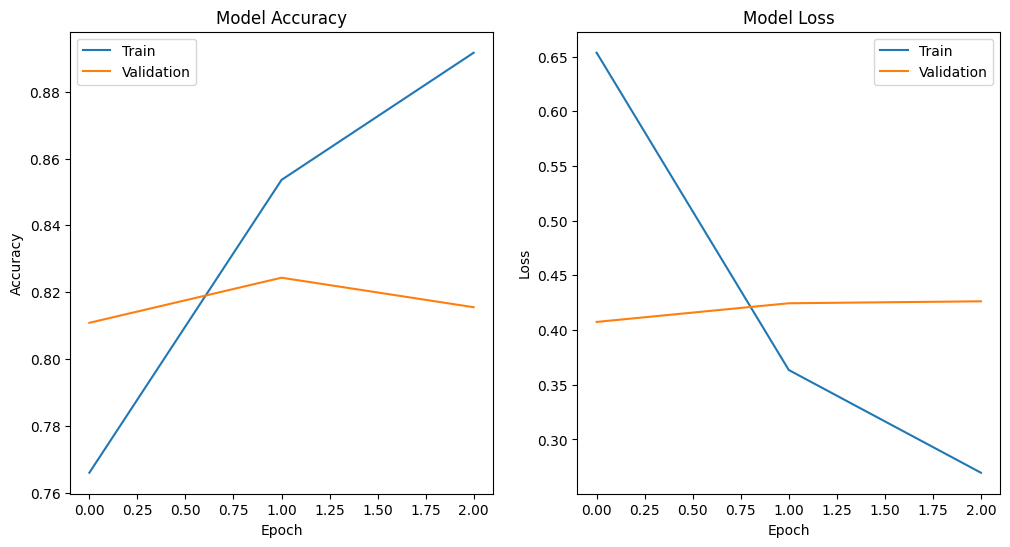

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


In [28]:
model.save('models/fake_image_vgg16_model_V1.h5')
print("Model saved as '/fake_image_vgg16_model.h5'")

Model saved as '/fake_image_vgg16_model.h5'


In [29]:
test_batches.class_indices

{'Real': 0, 'Fake': 1}

In [30]:
predictions = model.predict(x=test_batches,verbose=0)

In [31]:
predicted_classes = np.argmax(predictions, axis=1)

In [45]:
print(test_batches.classes)

[0 0 0 ... 1 1 1]


In [44]:
print(predicted_classes)

[0 0 0 ... 1 1 1]


In [32]:
true_labels = test_batches.classes

In [35]:
accuracy = accuracy_score(true_labels, predicted_classes)

In [36]:
print(f'Test Data Accuracy: {accuracy:.4f}')

Test Data Accuracy: 0.8202


In [33]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('models/fake_image_vgg16_model_V1.h5')

def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image

    # Predict using the model
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions, axis=1)[0]
    
    # Map class index to label
    labels = ['Real', 'Fake']
    predicted_class = labels[class_idx]
    
    return predicted_class

# Example usage
img_path = r"E:\Datasets\deep_fake_split\test\Fake\fake_2113.jpg"
prediction = predict_image(img_path)
print(f'The image is predicted as: {prediction}')


1/1 [==============================] - 0s 264ms/step
The image is predicted as: Fake


In [80]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    
    # Predict using the model
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions, axis=1)[0]
    
    # Print raw predictions for debugging
    print(f'Raw predictions: {predictions}')
    
    # Map class index to label
    labels = ['Real', 'Fake']
    predicted_class = labels[class_idx]
    
    return predicted_class

# Example usage
img_path = r"E:\Datasets\deep_fake_split\test\Fake\fake_2113.jpg"
prediction = predict_image(img_path, model)
print(f'The image is predicted as: {prediction}')


1/1 [==============================] - 0s 38ms/step
Raw predictions: [[0.48673442 0.5132656 ]]
The image is predicted as: Fake


Version two with l2 Reguralization

In [15]:
from tensorflow.keras.applications import VGG16
with tf.device('/CPU:0'):
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [16]:
for layer in vgg16_base.layers:
    layer.trainable = False

In [17]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# Define L2 regularization strength
l2_strength = 0.01

# Create the model
x = vgg16_base.output
x = Flatten()(x)
x = Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
x = Dropout(0.2)(x)
x = Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
x = Dense(units=2, activation='softmax')(x)

In [19]:
model = tf.keras.Model(inputs=vgg16_base.input, outputs=x)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True
)

In [23]:
history = model.fit(
    train_batches,              # Training data
    validation_data=valid_batches,  # Validation data
    epochs=3,                  # Number of epochs
    batch_size=20,             # Batch size
    callbacks=[early_stopping]  # Early stopping callback
)


Epoch 1/3
1400/1400 [==============================] - 396s 277ms/step - loss: 2.9310 - accuracy: 0.7200 - val_loss: 1.1838 - val_accuracy: 0.7863
Epoch 2/3
1400/1400 [==============================] - 384s 274ms/step - loss: 1.0649 - accuracy: 0.7787 - val_loss: 0.8405 - val_accuracy: 0.8022
Epoch 3/3
1400/1400 [==============================] - 397s 283ms/step - loss: 0.8648 - accuracy: 0.7941 - val_loss: 0.6882 - val_accuracy: 0.8067


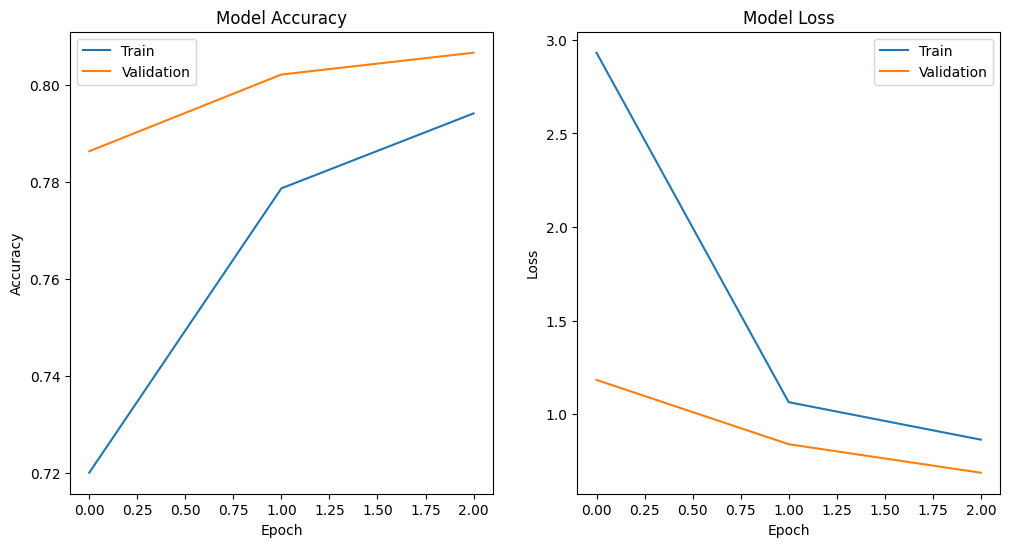

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


In [25]:
model.save('models/fake_image_vgg16_model_V2.h5')
print("Model saved as ake_image_vgg16_model_V2.h5")

Model saved as ake_image_vgg16_model_V2.h5


In [26]:
test_batches.class_indices

{'Real': 0, 'Fake': 1}

In [27]:
predictions = model.predict(x=test_batches,verbose=0)

In [28]:
predicted_classes = np.argmax(predictions, axis=1)

In [29]:
true_labels = test_batches.classes

In [30]:
accuracy = accuracy_score(true_labels, predicted_classes)

In [31]:
print(f'Test Data Accuracy: {accuracy:.4f}')

Test Data Accuracy: 0.8113


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [3]:
vgg16_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
x = vgg16_base.output
x = Flatten()(x)
x = Dense(units=256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
x = Dropout(0.2)(x)  # Dropout layer with 20% dropout rate
x = Dense(units=128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
x = Dense(units=2, activation='softmax')(x)

In [6]:
model = Model(inputs=vgg16_base.input, outputs=x)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=3,
    batch_size=10,  # Updated batch size
    callbacks=[early_stopping]
)

Epoch 1/3
   2/1400 [..............................] - ETA: 6:39:21 - loss: 7.9230 - accuracy: 0.5750